In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency


---

# **Project 설명**

* 비디오 게임 데이터를 통해 다음 분기에는 어떤 게임을 만들어야 하는가?

## **Key Points**



* 지역에 따라 선호하는 장르가 있는가?
* 연도별 게임 트렌드가 있는가?
* 매출이 높은 게임에 대한 분석 및 시각화 

---

# **Project 진행과정**

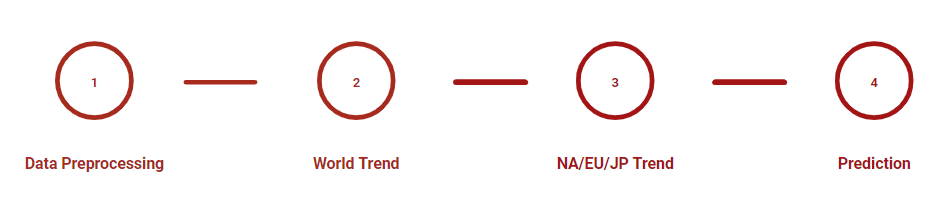

---

# **0. Data 확인**

* Data 불러오기 & Feature 확인
* Data shape / NaN / type 확인

---

### **(0.A) Data 불러오기 & Feature 확인**

In [38]:
# video game data 불러오기

df = pd.read_csv("/content/vgames2.csv")

# feature 확인
df.head(5)

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


**Features** : 
* **Name** : 게임 이름
* **Platform** :지원되는 게임 플랫폼
* **Year** :출시년도
* **Genre** : 장르
* **Publisher** :제작 회사
* **NA_Sales** :북미 매출액
* **EU_Sales** :유럽 매출액 
* **JP_Sales** :일본 매출액 
* **Other_Sales** :기타 지역 매출액
---

### **(0.B) 데이터 shape / NaN / type 확인**

In [39]:
# 데이터 확인

print("data shape : ", df.shape, end='\n\n')
print("NaN values : \n\n", df.isnull().sum(), end='\n\n')
print("data types : \n\n",df.dtypes)

# sales 부분이 object 인 것을 알 수 있다

data shape :  (16598, 10)

NaN values : 

 Unnamed: 0       0
Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

data types : 

 Unnamed: 0       int64
Name            object
Platform        object
Year           float64
Genre           object
Publisher       object
NA_Sales        object
EU_Sales        object
JP_Sales        object
Other_Sales     object
dtype: object


---

# **1. Data Preprocessing(1) - Modify Data**

* Remove NaN 

* **['Sales']** column
    * Object --> Float
    * Remove K & M --> million 단위로 환산

* **['Year']** column
  * format 변경 (ex. 86.0 --> 1986.0)

---

### **(1.A) Remove NaN**

In [40]:
# NaN 값은 보지 않겠다 (데이터 사이즈가 충분히 크므로 고려하지 않아도 될 것 같다)

columns = ['Year','Genre','Publisher']
df = df.fillna('0')
for i in columns : 
  nan_indexes = df[df[i]=='0'].index.tolist()
  df = df.drop(nan_indexes)

print("after excluding NaN values, data shape : ",df.shape)

# 변경 후, (16598 X 10) 사이즈에서 (16241 X 10) 으로 축소되었다

after excluding NaN values, data shape :  (16241, 10)


---
### **(1.B) sales columns float type으로 변경**

In [41]:
# sales 관련 column 확인

df['NA_Sales'].value_counts()

# M 또는 K 가 붙여져 있는 것 확인

0       4367
0.02     524
0.03     518
0.01     516
0.04     515
        ... 
170K       1
5.54       1
4          1
2.95       1
5.08       1
Name: NA_Sales, Length: 489, dtype: int64

In [42]:
df['EU_Sales'].value_counts()

0        5543
0.01     1443
0.02     1230
0.03      905
0.04      719
         ... 
4.3         1
1.64        1
90K         1
2.29M       1
960K        1
Name: EU_Sales, Length: 360, dtype: int64

In [43]:
# sales 관련 column 을 float 화 시키는 함수 

# 마지막 위치가 'M' 이면 'M' 만 빼준 형태로 반환
# 마지막 위치가 'K' 이면 0.001을 곱해준 형태로 반환 
# 그 외엔 float으로 바꿔주는 형태로 반환 

def tofloat(value) :
  if value[-1] == 'M' :
    return float(value[:-1])
  elif value[-1] == 'K' :
    return float(value[:-1])*0.001
  else :
    return float(value)

# sales 관련 column 을 float 화 시키기

sales = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales']

for i in sales :
  df[i] = df[i].apply(tofloat)

# 확인용

df['NA_Sales'].value_counts()


0.00     4421
0.02      536
0.03      523
0.01      521
0.05      519
         ... 
4.98        1
14.97       1
0.47        1
3.25        1
6.05        1
Name: NA_Sales, Length: 410, dtype: int64

---
### **(1.C) Year column 숫자 형태 변환**

In [44]:
# Year column 숫자 확인

print(df['Year'].value_counts(),end='\n\n')

# 년도에 19 또는 20 없는 것 확인

# --------------------------------------------

# 1900 년도 이하의 숫자가 있는지 확인 ==> 있는 것 확인 

df[df['Year']<=1900]['Year'].value_counts()

2009.0    1418
2008.0    1413
2010.0    1246
2007.0    1192
2011.0    1123
          ... 
97.0         2
1.0          2
86.0         1
94.0         1
2020.0       1
Name: Year, Length: 62, dtype: int64



11.0    10
9.0     10
8.0     10
10.0     7
3.0      7
6.0      7
16.0     5
15.0     5
4.0      4
5.0      4
95.0     4
0.0      3
7.0      3
2.0      3
98.0     3
96.0     3
1.0      2
13.0     2
14.0     2
12.0     2
97.0     2
94.0     1
86.0     1
Name: Year, dtype: int64

In [45]:
# 확인용

# year column 에서 각 data별 마지막 위치에 있는 값이 '0' 이 아닌 경우가 있는지 확인  

for i in df['Year'] :
  if str(i)[-1] != '0' :
    print(i)

# 아무것도 출력이 되지 않는다 ==> year는 float가 아닌 int형으로 바꿔주자

In [46]:
# Year column 형태 변환 함수

# string으로 바꿔준다 
# length 가 3 이면 앞에 '200' 추가 (ex. 1.0 이면 --> 2001)
# length 가 4 일 때 ,
# data 의 맨 앞에 위치한 값이 '1' 이면 '20' 추가 (10.0 이면 --> 2010)
# data 의 맨 앞에 위치한 값이 '1' 이 아니면 '19' 추가 (86.0 --> 1986)

def year_tuning (value) :
  if len(str(value)) == 3:
    return int(float('200' + str(value)))
  elif len(str(value)) == 4:
    if str(value)[0] == '1' :
      return int(float('20' + str(value)))
    else :
      return int(float('19' + str(value)))
  else :
    return int(float(value))

In [47]:
# Year column 형태 변환 적용

df['Year'] = df['Year'].apply(year_tuning)

In [48]:
# year column 에 있는 data가 잘 있는지 확인 

sum = 0
for i in df['Year'] :
  if len(str(i)) == 4 :
    sum +=1
sum

# data의 row 갯수와 일치

16241

---
### **(1.D) 데이터가 잘 처리 되었는지 확인**


In [49]:
# modified 된 data types & nan 값 다시 확인 

print("modified data types : \n\n", df.dtypes,end='\n\n')
print("modified NaN values : \n\n",df.isnull().sum())

# Year column은 int형
# Sales column은 float형 
# NaN값은 없는 것 확인

modified data types : 

 Unnamed: 0       int64
Name            object
Platform        object
Year             int64
Genre           object
Publisher       object
NA_Sales       float64
EU_Sales       float64
JP_Sales       float64
Other_Sales    float64
dtype: object

modified NaN values : 

 Unnamed: 0     0
Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64


---

# **1. Data Preprocessing(2) - Remove Data**

* 2000년 대 이전 출시된 게임들은 보지 않겠다
* 오래된 Platform은 보지 않겠다

<br/>

\- 오래된 게임들은 현재 트렌드를 분석하는데 방해가 될 수 있다

\- Ex) 1989년도에 출시된 테트리스라는 게임은 매출이 높다는 것을 알 수 있다

\- 현재 데이터는 총 매출액에 대한 지표를 보여줄 뿐, 년도별 매출액의 증감추이를 알 수 없다

\- 따라서, 그 당시에 인기가 많아서 매출에도 영향을 주었는지, 꾸준히 인기가 많았는지 알 수 없다

\- 하지만 그 당시 지원되는 플랫폼(GB,NES)으로 볼 때 , 꾸준히 인기가 많았다고 보기 힘들다.

\- 결론적으로, 2000년대 이전 출시된 게임 & 오래된 Platform은 빼고 보겠다

---


In [50]:
# Tetris 데이터 확인용 
df[df['Name']=='Tetris']

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
1203,1204,Tetris,GB,1989,Puzzle,Nintendo,23.20,2.26,4.22,0.58
11053,11054,Tetris,NES,1988,Puzzle,Nintendo,2.97,0.69,1.81,0.11


---

### **(1.A) 2000년 이전 데이터 없애기**

In [51]:
df = df[df['Year'] >= 2000]

---
### **(1.B) 오래된 Platform 없애기**

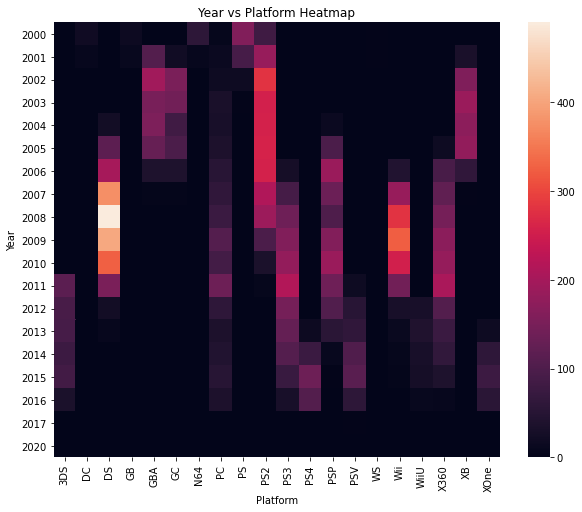

In [52]:
# 오래된 platform 확인

year_vs_platform_df = pd.crosstab(df['Year'],df['Platform'])

# heatmap (year vs platform)

plt.figure(figsize=(10,8))
sns.heatmap(year_vs_platform_df);
plt.title("Year vs Platform Heatmap");

# DC / GB / N64 / WS 제거

In [53]:
# DC / GB / N64 / WS 제거

# platform 제거 함수
def remove_platform_fn(platform) :
  global df
  index = df[df['Platform']==platform].index.tolist()
  df = df.drop(index)
  return df

df = remove_platform_fn('DC')
df = remove_platform_fn('GB')
df = remove_platform_fn('N64')
df = remove_platform_fn('WS')

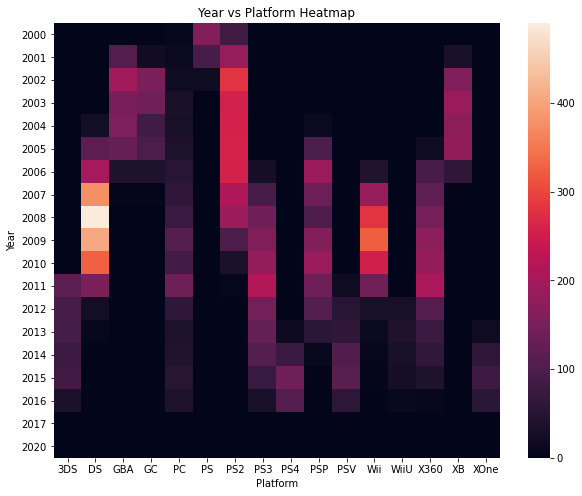

In [54]:
# heatmap 다시 확인

year_vs_platform_df = pd.crosstab(df['Year'],df['Platform'])

# heatmap (year vs platform)

plt.figure(figsize=(10,8))
sns.heatmap(year_vs_platform_df);
plt.title("Year vs Platform Heatmap");

# 제거된 것 확인

#### **Analysis**

\- 시간이 지남에 따라 platform이 업그레이드 되는 것을 알 수 있다

\- ex) PS --> PS2 --> PS3 --> PS4

\- platform이 업그레이드 됨에 따라 이에 맞는 게임들이 많이 출시되는 경향을 보인다

\- 그리고 이전 platform에 대한 게임들의 출시 빈도수는 감소하는 경향을 보인다 

---

# **2. World Trend Analysis**

* Genre vs Year Analysis
  * 2-sample $\chi^2$ test
    * $H_0$ : 두 그룹은 서로 독립이다
    * $H_1$ : 두 그룹은 서로 독립이 아니다

* Genre vs Total Sales Analysis
  * 의미있는 Genre 추출

* Game Analysis

---

In [55]:
# DataFrame 정리

df = df.drop('Unnamed: 0',axis=1)

df = df.reset_index().drop('index',axis=1)

---

### **(2.A) Genre vs Year Analysis**

**2-Sample $\chi^2$ test**

* $H_0$ : 두 그룹은 서로 독립이다 (Year 와 Genre는 상관이 없다)
* $H_1$ : 두 그룹은 서로 독립이 아니다 (Year와 Genre는 상관이 있다)

In [56]:
# Genre & Year에 대한 2-sample chisquare test

genre_vs_year_df = df[['Year','Genre']]

obs = pd.crosstab(genre_vs_year_df['Year'],genre_vs_year_df['Genre'])

chi2_contingency(obs)[1]

1.2340707113175348e-260

\- pvalue는 매우 작으므로 유의구간 5%에 두 개의 데이터는 서로 독립이다라는 귀무가설은 기각할 수 있다.

\- Genre와 Year는 관련성이 있다는 것을 알 수 있다. 

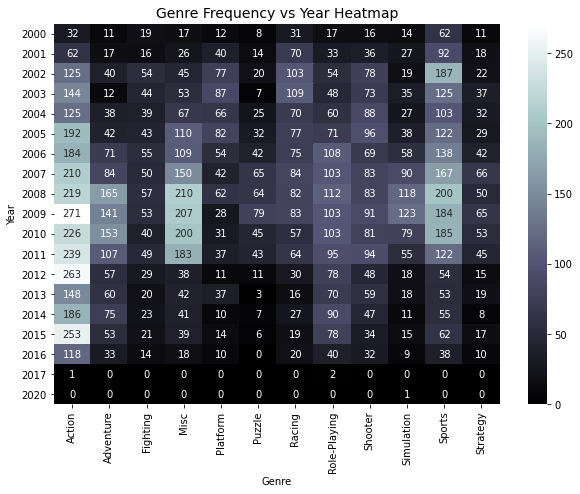

In [57]:
# genre vs year (Heatmap) 시각화

year_vs_genre_df = pd.crosstab(df['Year'],df['Genre'])
plt.figure(figsize=(10,7))
sns.heatmap(year_vs_genre_df,annot=True,fmt='0.0f',cmap='bone');
plt.title("Genre Frequency vs Year Heatmap",fontsize=14);


#### **Analysis**

\- 장르별로 분석해보면 특정 구간에 빈도수가 가장 높고 그 전/후로 서서히 낮아지는 정규 분포 형태를 띈다는 것을 알 수 있다

\- 빈도수가 높은 구간(연하게 칠한 부분)이 많다는 의미는 해당 장르가 인기가 많기 때문이라고 생각한다

\- 따라서, 이런 장르의 총 매출액도 높을 것이다는 가설을 세우고 분석을 해보겠다 

(Action --> Sports --> Misc --> Adventure)

---

### **(2.B) Genre vs Total Sales Analysis**

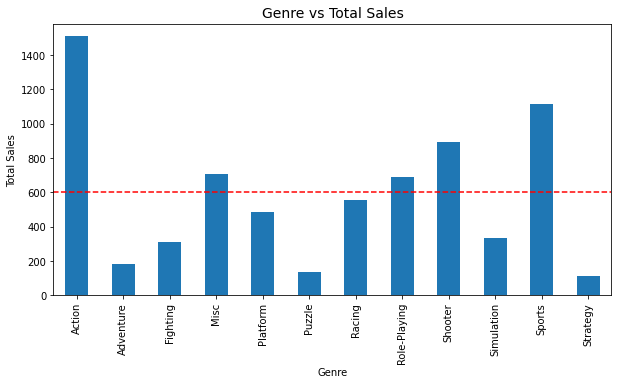

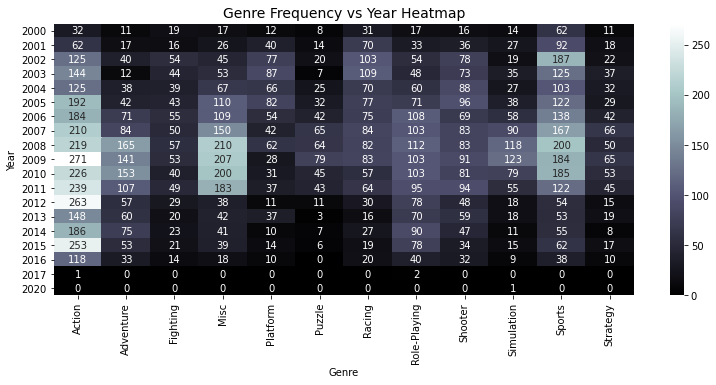

In [58]:
# genre vs total sales (barplot) 시각화

genre_vs_sales_df = df[['Genre','NA_Sales','EU_Sales','JP_Sales','Other_Sales']]
genre_vs_tot_sales_df = genre_vs_sales_df.groupby('Genre').sum().sum(axis=1)

genre_vs_tot_sales_df.plot.bar(ylabel='Total Sales',figsize=(10,5));
plt.axhline(y=600,color='red',linestyle='--');
plt.title("Genre vs Total Sales",fontsize=14)

# genre vs year 와 비교 분석

plt.figure(figsize=(13,5))
sns.heatmap(year_vs_genre_df,annot=True,fmt='0.0f',cmap='bone');
plt.title("Genre Frequency vs Year Heatmap",fontsize=14);


#### **Analysis** 

\- 총매출이 높다는 뜻은 해당 장르의 게임이 인기가 많다는 의미라고 볼 수 있다

\- 가설 
  * 출시 빈도수가 높을수록 총 매출액도 높을 것이다
  * 빈도수로 본 매출액 예상 순위
  * Action --> Sports --> Misc --> Adventure

\- **실제 매출 1/2 위** : Action & Sports 
* 출시 빈도수가 높을수록 총 매출액도 높을 것이라는 추측이 맞아떨어진다

\- **실제 매출 3 위** : Shooter
* Misc 장르가 3위를 차지할 것이라고 생각했지만 아니였다
* Shooter 장르의 년도별 출시 빈도수를 보면 그렇게 많아보이진 않지만 총 매출은 3위를 한 것을 알 수 있다

\- Adventure 장르를 보면 출시 빈도수는 높아보이지만 총 매출은 낮다는 것을 알 수 있다 

\- 상위 3개 장르의 매출이 높은 게임들을 분석해보자

---




### **(2.C) Game Analysis**

In [59]:
# 특정 장르만 추출하는 함수 (total sales feature 추가)

def genre_fn(genre) :
  global df
  new_df = pd.DataFrame()
  index = df[df['Genre']==genre].index.tolist()
  new_df = pd.concat([new_df,df.loc[index]])
  new_df['Sum_Sales'] = new_df[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum(axis=1)
  return new_df 

# action / shooter / sports 개별 dataframe 생성

action_df = genre_fn('Action')
shooter_df = genre_fn('Shooter')
sports_df = genre_fn('Sports')

In [60]:
# 상위권 action 장르 게임 (tot sales 10M 이상)

top_action_df = action_df[action_df['Sum_Sales']>=10.0].sort_values(by=['Sum_Sales'],ascending=False)

# 상위권 Sports 장르 게임 (tot sales 5M 이상)

top_sports_df = sports_df[sports_df['Sum_Sales']>=5.0].sort_values(by=['Sum_Sales'],ascending=False)

# 상위권 shooter 장르 게임 (tot sales 10M 이상)

top_shooter_df = shooter_df[shooter_df['Sum_Sales']>=10.0].sort_values(by=['Sum_Sales'],ascending=False)


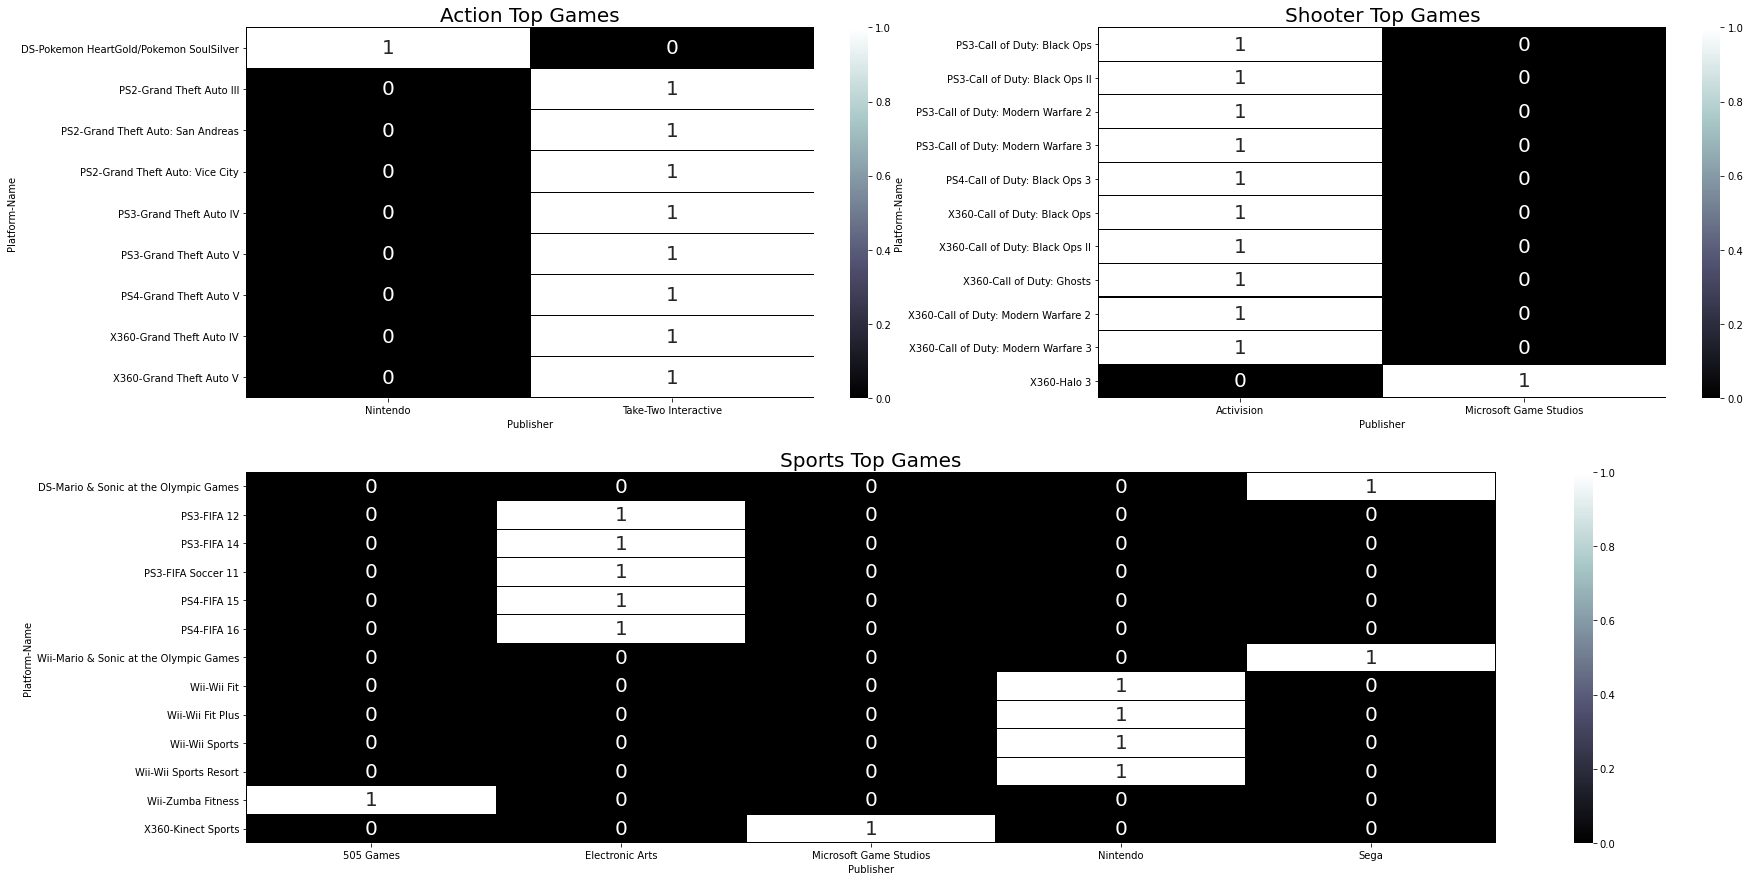

In [61]:
# top 3 genre 상위권 게임 분석 (heatmap) 시각화 

obs1 = pd.crosstab([top_action_df['Platform'],top_action_df['Name']],top_action_df['Publisher'])
obs2 = pd.crosstab([top_sports_df['Platform'],top_sports_df['Name']],top_sports_df['Publisher'])
obs3 = pd.crosstab([top_shooter_df['Platform'],top_shooter_df['Name']],top_shooter_df['Publisher'])

plt.figure(figsize=(28,15))
#plt.subplots_adjust(top=5,bottom=3,left=3,right=6.5)

plt.subplot(2,2,1)
sns.heatmap(data=obs1,annot=True,fmt='0.0f',cmap='bone',linecolor='black',linewidths=0.1,annot_kws={'size':20});
plt.title("Action Top Games",fontsize=20);

plt.subplot(2,1,2)
sns.heatmap(data=obs2,annot=True,fmt='0.0f',cmap='bone',linecolor='black',linewidths=0.1,annot_kws={'size':20});
plt.title("Sports Top Games",fontsize=20);

plt.subplot(2,2,2)
sns.heatmap(data=obs3,annot=True,fmt='0.0f',cmap='bone',linecolor='black',linewidths=0.1,annot_kws={'size':20});
plt.title("Shooter Top Games",fontsize=20);


#### **Analysis**

\- **공통 Keyword**

  * PlayStation 관련 platform 쓰이고 있다
  * 시리즈물이 많다 
    * Action : Grand Theft Auto
    * Shooter : Call of Duty
    * Sports : FIFA & Wii

---

# **3. Country Trend Analysis**

* Country Sales Relationship
  * ANOVA test
    * $H_0$ : 모든 그룹의 평균은 같다
    * $H_1$ : 적어도 한 그룹의 평균에 차이가 있다

* Genre vs NA , EU , JP Sales Analysis

* Game Analysis

---

### **(3.A) Country Sales Relationship**

**Anova test**

* $H_0$ : 모든 그룹의 평균은 같다 (나라별 sales는 같은 평균을 가질 것이다)
* $H_1$ : 적어도 한 그룹의 평균에 차이가 있다 (나라별 sales 중 적어도 한 나라의 평균에 차이가 있을 것이다)

In [62]:
# 나라별 sales 담기

sales_df = df[['NA_Sales','EU_Sales','JP_Sales']].copy()

# tidy 형태로 바꿔주기

melted_df =  pd.melt(sales_df.reset_index(),id_vars=['index'],var_name='Country',value_name='Sales')

In [63]:
# 나라별 sales ANOVA-test

import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('Sales ~ C(Country)', data=melted_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Country),256.390568,2.0,455.663416,1.597659e-196
Residual,11935.188001,42423.0,NaN,NaN


\- pvalue가 매우 작으므로 유의구간 5%에 모든 그룹의 평균이 같다는 귀무가설은 기각할 수 있다.

\- 즉, 나라별 sales 는 다른 평균을 가질 것이다는 추측을 할 수 있다
  * 나라별 인구수의 차이가 있기 때문에 당연한 결과라고 할 수 있다

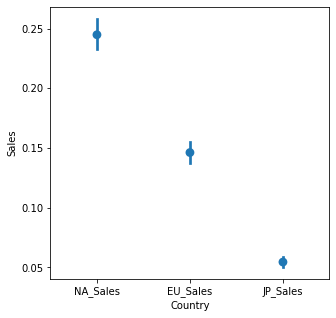

In [64]:
# NA/EU/JP sales (pointplot) 시각화

plt.figure(figsize=(5,5))
sns.pointplot(x=melted_df['Country'],y=melted_df['Sales'],ci=95,linestyles='none');


\- 시각화를 해본 결과, 나라별 sales에 차이가 있음을 알 수 있다

---

### **(3.B) Genre vs NA , EU , JP Sales Analysis**

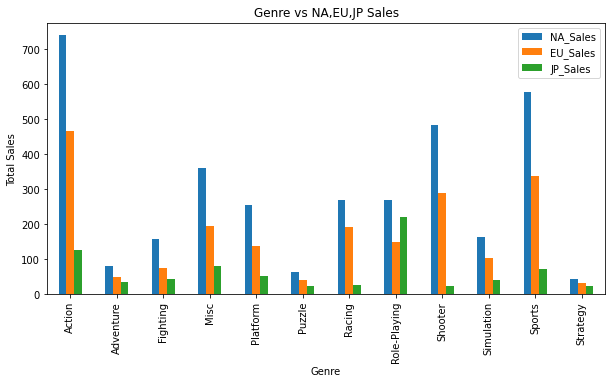

In [65]:
# genre vs sales

genre_vs_sales_df = df[['Genre','NA_Sales','EU_Sales','JP_Sales']]
genre_vs_country_sales_df = genre_vs_sales_df.groupby('Genre').sum()

genre_vs_country_sales_df.plot.bar(ylabel='Total Sales',figsize=(10,5),title='Genre vs NA,EU,JP Sales');



#### **Analysis**

\- top 장르
  * NA : Action / Sports / Shooter
  * EU : Action / Sports / Shooter
  * JP : Role-playing / Action / Sports 

* 미국 과 EU는 전체적인 트렌드와 비슷한 경향을 띄지만 일본은 아니다. 
* 일본은 role-playing 장르가 제일 높았다

\- 나라별 매출액이 높은 게임들을 살펴보자

---

### **(3.C) Game Analysis**

In [66]:
# 나라별 sales 내림차순 정렬

JP_df = df.sort_values(by=['JP_Sales'],ascending=False)
EU_df = df.sort_values(by=['EU_Sales'],ascending=False)
NA_df = df.sort_values(by=['NA_Sales'],ascending=False)

# JP 상위권 게임 (tot sales 4M 이상)

top_JP_df = JP_df[JP_df['JP_Sales']>=4.0]

# NA 상위권 게임 (tot sales 10M 이상)

top_NA_df = NA_df[NA_df['NA_Sales']>=10.0]

# EU 상위권 게임 (tot sales 8M 이상)

top_EU_df = EU_df[EU_df['EU_Sales']>=8.0]

# 장르 별 빈도수를 담을 dataframe 생성

top_JP_genre_df = top_JP_df.groupby('Genre').Genre.count()
top_NA_genre_df = top_NA_df.groupby('Genre').Genre.count()
top_EU_genre_df = top_EU_df.groupby('Genre').Genre.count()

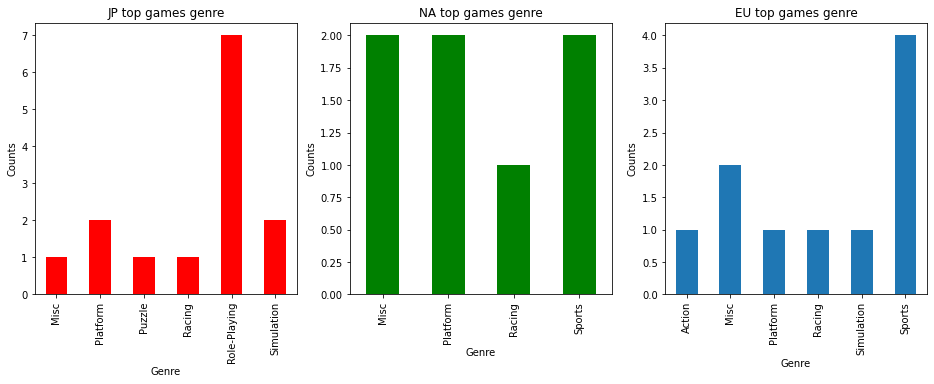

In [67]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
top_JP_genre_df.plot.bar(ylabel='Counts',title='JP top games genre',color='red')

plt.subplot(1,3,2)
top_NA_genre_df.plot.bar(ylabel='Counts',title='NA top games genre',color='green');

plt.subplot(1,3,3)
top_EU_genre_df.plot.bar(ylabel='Counts',title='EU top games genre');

#### **Analysis**

\- JP : role-playing 장르의 빈도수가 장르가 가장 높다

\- NA : 빈도수가 골고루 퍼져있다

\- EU : 빈도수가 골고루 퍼져있지만 sports 장르가 그나마 높다

\- keyword 

  * 겹치는 장르 : misc / platform / racing
  * 나라별 상위권의 게임들에서는 action 장르의 게임을 찾아보기 어렵다
  * 그럼에도 action 장르 게임의 총 매출액이 높은 이유?
    * 출시 빈도수가 다른 장르에 비해 높다
    * 사람들이 action 장르의 다양한 게임들을 많이 애용하고 있다고 볼 수 있다 

---

# **4. Conclusion**

  * Summary

  * Problem

  * Further Analysis

  * Prediction

---




### **(4.A) Summary**

* World Trend 
    * Action & Sports : 출시 빈도수도 높고 매출도 높다
    * Shooter : 출시 빈도수가 높진 않지만 매출은 높다 

* NA , EU , JP Trend
  * NA & EU :  장르별 총 매출액이 전체적인 트렌드와 비슷한 경향을 보인다
  * JP : 전체적인 트렌드와는 달리 role-playing 장르의 총 매출액이 가장 높다

<br/>

\- 기준에 따라 설계해야될 게임들의 장르가 다르다
  * 일본 시장: role-playing
  * 나라 공통 : misc / platform / racing
  * 높은 매출 : action / sports / shooting 

---

### **(4.B) Problem**

\- 하지만 짚고 넘어갈 점들이 있다






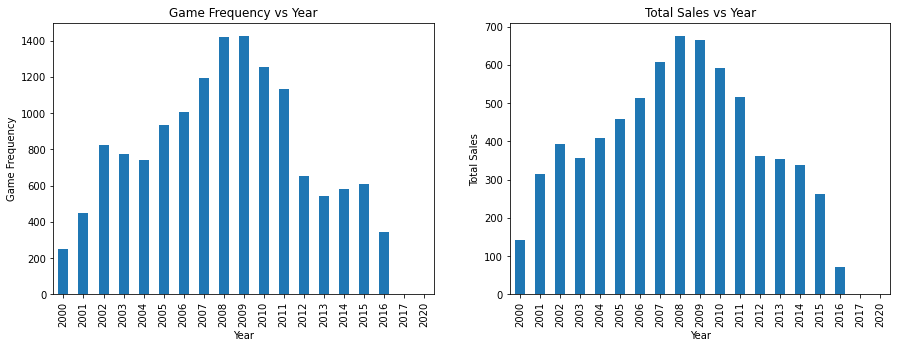

In [68]:
country_df = df[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].copy()
tot_sales = country_df.sum(axis=1)
df1 = df.copy()

df1['tot_sales'] = tot_sales

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df.groupby('Year').Year.count().plot.bar(ylabel='Game Frequency',title='Game Frequency vs Year');

plt.subplot(1,2,2)
df1.groupby('Year').tot_sales.sum().plot.bar(ylabel='Total Sales',title='Total Sales vs Year');

1. 게임 출시 빈도수가 점점 낮아지고 있다 
* 스마트폰의 대중화가 비디오 게임 출시 빈도수에 영향을 미쳤을 것으로 생각한다 
  * 스마트폰은 가지고 있지 않은 사람보다 가지고 있는 사람들이 많다고 본다 
  * 반면에 게임 platform(PS / Wii)은 가지고 있는 사람보다 가지고 있지 않은 사람들이 더 많다고 본다
  * 따라서 스마트폰용 게임들이 접근성이 높을 것이다
* 출시 빈도수가 낮아짐에 따라 년도별 총 매출액도 낮아지고 있는 추세이다

---





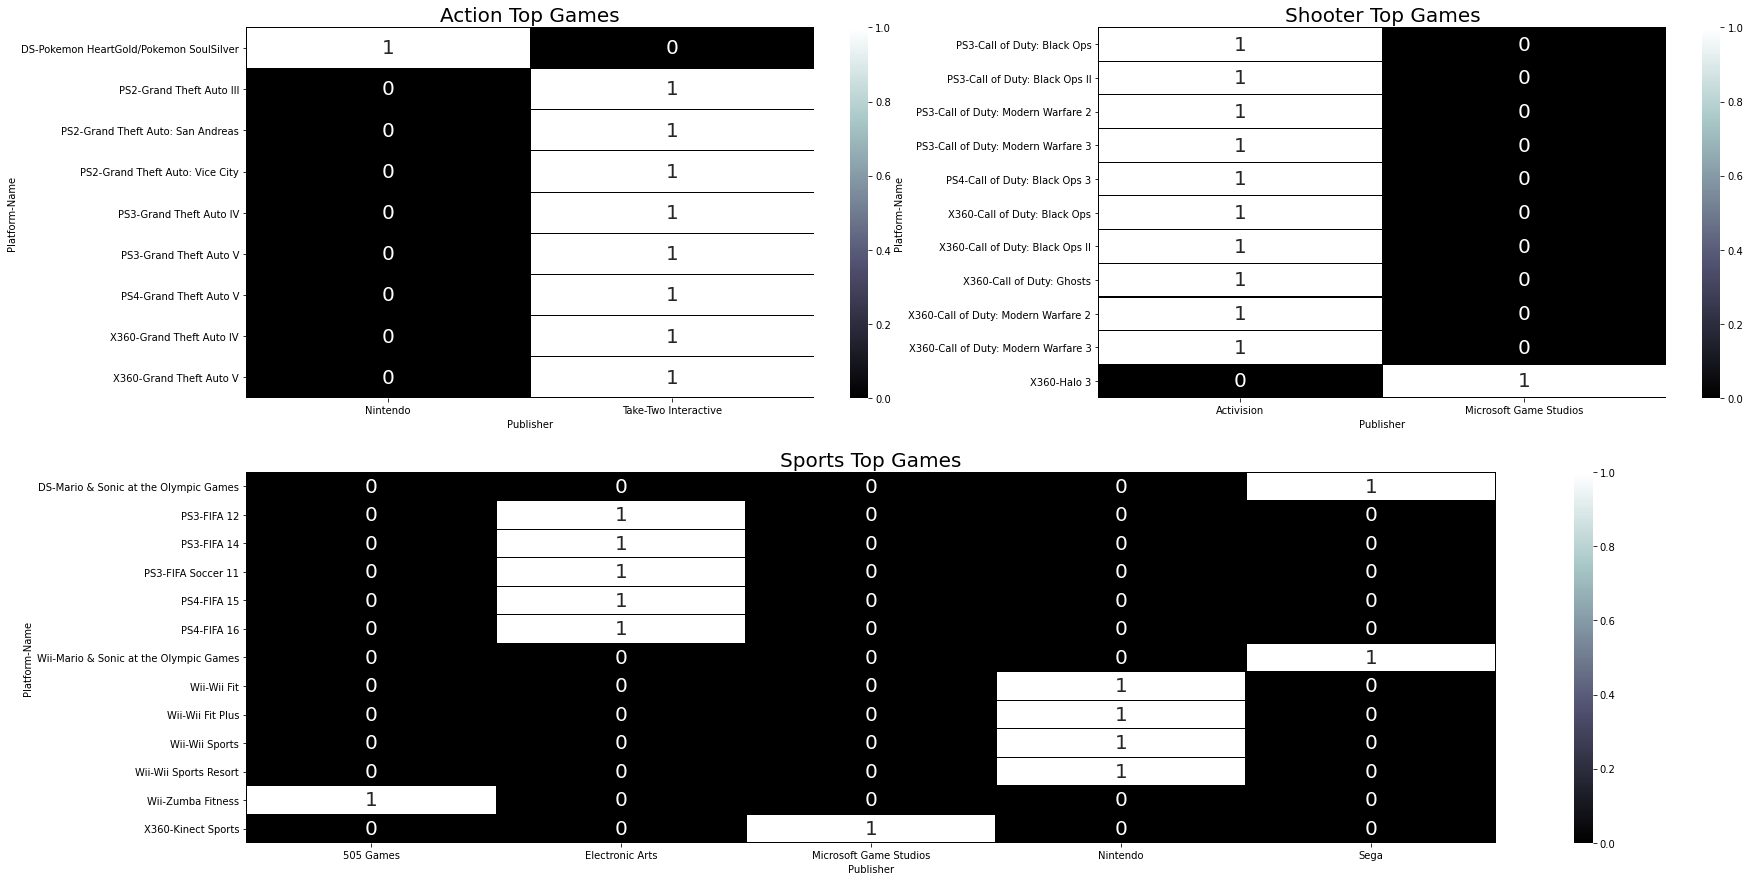

2. 매출이 높은 게임들을 보면 대부분이 시리즈물이라는 점이다
  * 즉, 첫 작품은 이미 큰 성공을 거둔 작품이다 (ex. GTA 3 --> GTA 4 --> GTA 5)
  * 그리고, 소비자 입장에서 다음 출시될 게임이 기대가 된다는 의미이다
  * 따라서, 게임을 신중하게 설계해야 이런 게임들과의 경쟁에서도 승산이 있을 것이다

---

### **(4.C) Further Analysis**

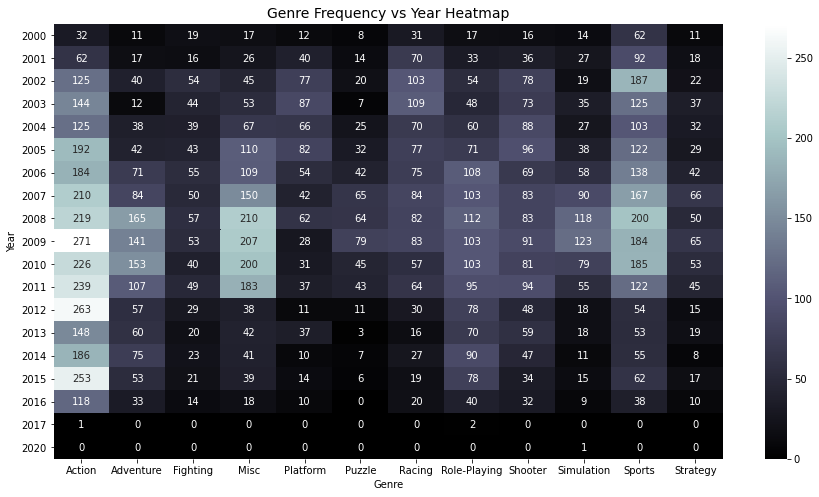

#### **Analysis**

\- 연도별 특정 장르의 게임 출시 빈도수를 보면 action 장르의 게임이 최근까지도 빈번하게 출시되고 있다는 것을 알 수 있다

\- 게임 제작 회사들은 게이머들의 action 장르에 대한 욕구를 충족시키기 위한 움직임으로 해석된다

\- 그렇기 때문에 action 장르의 게임이 이익 창출면에서 유리할 것이다

\- 하지만 이 같은 게임들은 이미 많이 출시된 상태이기 때문에 신중한 결정이 필요하다





#### **GTA & COD 분석 (action & shooting 장르의 매출 높은 게임)**

GTA  

* action 장르로 분류되지만 엄밀히 따지고 보면 action-adventure 장르이다
* 게임 캐릭터가 도시에서 일어나는 사건들을 하나씩 해결해나가는 스토리로 진행된다

COD 

* 1-인칭 shooting 게임
* 전쟁을 배경 (2차 세계대전, 냉정, etc)으로 적군들과 싸워서 이겨나가는 스토리로 진행된다

공통점 

* 방대한 세계관을 가지고 있다
* 끊임없는 스토리로 진행된다
* 모바일용 버전을 출시했다

---



### **(4.D) Prediction**

* 그래픽 
    * 현재의 기술로 충분히 고사양의 그래픽의 게임을 제작할 수 있을 것이다

* 내용
    * 방대한 세계관 구축 + 영화같은 스토리라인

* 장르
  * action (adventure + shooter + role-playing)

* 제작 과정
  * 하나의 게임에 다 담지말고 나눠서 진행 (ex. 1탄 --> 2탄 --> 3탄)

* 다각화
  * 비디오 게임 뿐만 아니라 사업 다각화를 염두해두고 진행
  * ex) 영화화 / 스마트폰용 게임 출시



하나의 게임을 만든다라기보단 기존엔 없었던 하나의 세계관을 만드는 것에 포커스를 두고 제작을 해야 된다고 생각합니다. 잘 짜여진 세계관에 탄탄한 스토리까지 갖춰진다면 시리즈물로도 제작이 가능하므로 게이머들이 지속적으로 다음 작품이 기대가 되게끔 할 수 있습니다. 

장르 같은 경우에는 최근까지도 많이 출시되고 있는 action 장르를 기준으로 잘 만들어진 세계관에 맞게 shooting이나 adventure 같은 부가적인 장르들을 포함시킨다면 여러 게이머들의 니즈를 충족시킬 수 있지 않을까 하는 생각이 듭니다. 

마지막으로 영화화나 모바일용 버전 출시 같은 사업 다각화를 고려하고 게임을 제작한다면 치열한 게임시장에서 살아남을 수 있을 것이라는 조심스러운 예측을 해봅니다.